# PSF profile

This notebook is a little digression on looking at the radial profile of the PSFs computed in this project with PSFEx.

In [5]:
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib import patheffects
from astropy.io import fits, ascii
import astropy.units as u
from astropy.table import Table
from photutils.profiles import RadialProfile

plt.rcParams['xtick.labelsize']='large'
plt.rcParams['ytick.labelsize']='large'
plt.rcParams['axes.labelsize']='x-large'
plt.rcParams['legend.fontsize']='medium'
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
# %matplotlib ipympl

First, we load the different PSFs file (here done automatically).

In [16]:
field = 'GDS'
psf_list = glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/psfex/{field}/*star_psf.psf")
filter_list = [re.search("f{1}\d+\w{1}",psf).group() for psf in psf_list]
psf_list, filter_list = zip(*sorted(zip(psf_list, filter_list)))

Then we show the different PSFs.

In [19]:
# Color dictionaries to make the plot nicer with colored filter names
color_dict = {'F090W':'#0000E3', 
              'F115W':'#1020FF',
              'F150W':'#0162FF',
              'F182M':'#00B1FF',
              'F200W':'#04D1FF',
              'F210M':'#02E8F4',
              'F250M':'#55FFAE',
              'F277W':'#87FF7F',
              'F300M':'#AAFF57',
              'F335M':'#EBFF0C',
              'F356W':'#FFD807',
              'F410M':'#FF6D03',
              'F430M':'#FF3F00',
              'F444W':'#FF330C',
              'F460M':'#DF0606',
              'F480M':'#B20000',}
channel_dict = {'F090W':'SW', 'F115W':'SW', 'F150W':'SW', 'F182M':'SW', 'F200W':'SW', 'F210M':'SW',
                'F250M':'LW', 'F277W':'LW', 'F300M':'LW', 'F335M':'LW', 'F356W':'LW', 'F410M':'LW', 'F430M':'LW', 'F444W':'LW', 'F460M':'LW', 'F480M':'LW'}
channel_color_dict = {'SW' : '#0162FF', 'LW' : '#FF330C'}

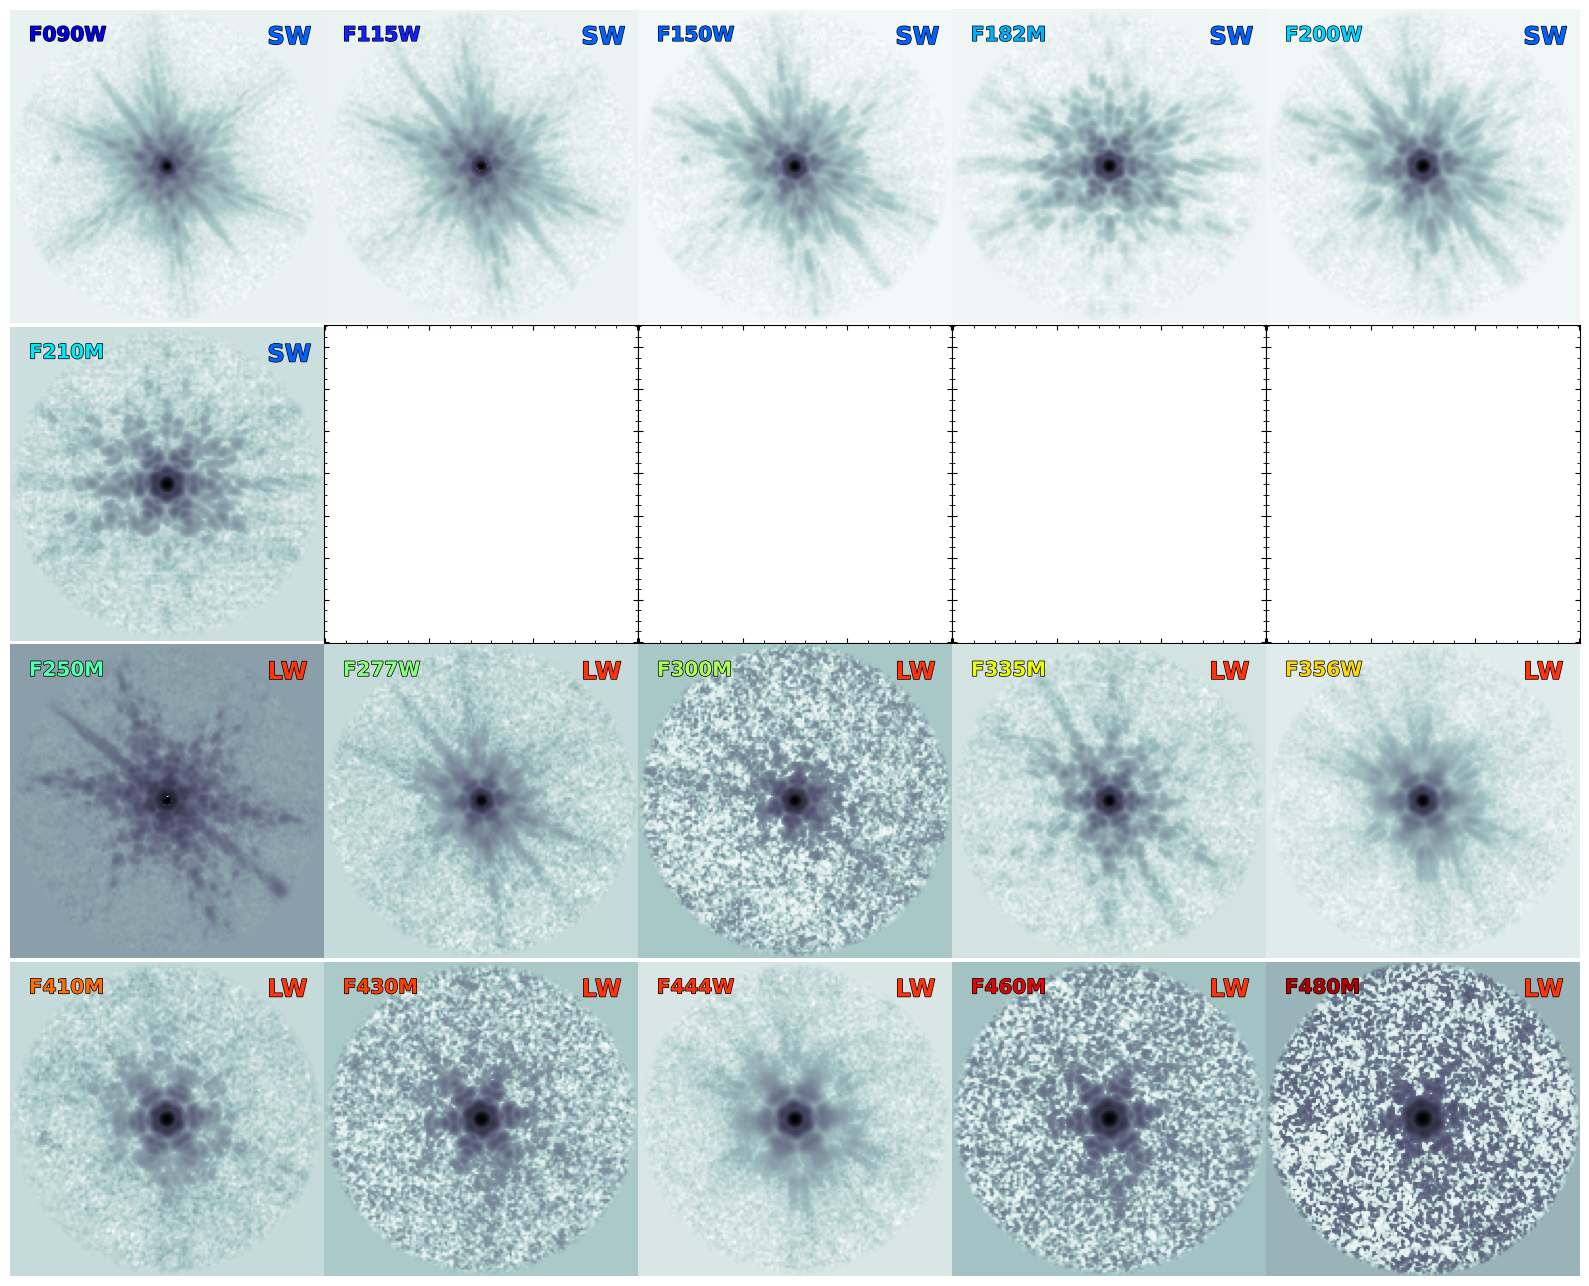

In [20]:
# Auto-sized plot to display all the PSFs
channel, count = np.unique([channel_dict[filter.upper()] for filter in filter_list], return_counts=True)
channel_count = dict(zip(channel, count))

w = min(5,channel_count[max(channel_count, key=channel_count.get)])
h = sum([-(channel_count[channel]//-w) for channel in channel_count])

fig, axs = plt.subplots(h,w,figsize=(3*w+1,3*h+1), sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})

for i, filter in enumerate(filter_list):
    image = fits.open(psf_list[i])

    if (len(channel_count)==2) & (channel_dict[filter.upper()]=="LW"):
        i += max(0, channel_count["LW"]-channel_count["SW"])
    ax = axs.flatten()[i] if type(axs)==np.ndarray else axs

    psf = image[1].data[0][0][0]
    image.close()

    ax.set_axis_off()
    ax.imshow(psf, origin='lower', cmap='bone_r', norm=SymLogNorm(linthresh=1e-5, linscale=0.8))
    ax.text(0.06, 0.9, filter.upper(), transform=ax.transAxes, 
            fontsize='x-large', fontweight='bold', 
            color=color_dict[filter.upper()],
            path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])
    ax.text(0.82, 0.89, channel_dict[filter.upper()], transform=ax.transAxes, 
            fontsize='xx-large', fontweight='bold', 
            color=channel_color_dict[channel_dict[filter.upper()]],
            path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])
    
fig.tight_layout()
# fig.savefig(f"/home/ec2-user/DAWN/DJA-SEpp/psfex/GDS/PSF_summary_{field}.pdf", bbox_inches='tight', pad_inches=0)
# fig.savefig(f"/home/ec2-user/DAWN/DJA-SEpp/psfex/GDS/PSF_summary_{field}.png", bbox_inches='tight', pad_inches=0, dpi=100)
plt.show()

Here we compute the radial profile for each PSF using `photutils`.

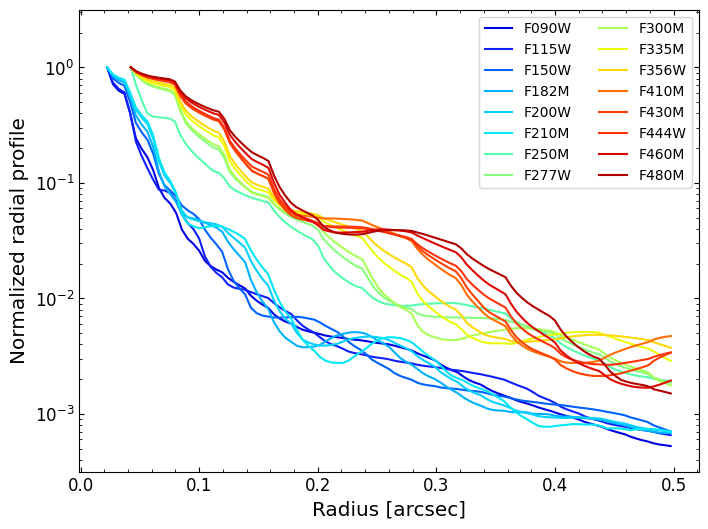

In [22]:
pixel_size = {'SW': 0.02*u.arcsec, 'LW': 0.04*u.arcsec} # arcsec/px

FWHM = {'wavelength':[], 'fwhm':[], 'fwhm_psfex':[]}

fig, ax = plt.subplots(figsize=(8,6))
for i, filter in enumerate(filter_list):
    image = fits.open(psf_list[i])
    psf = image[1].data[0][0][0]
    FWHM['fwhm_psfex'].append(image[1].header['PSF_FWHM']*pixel_size[channel_dict[filter.upper()]].value)
    image.close()
    radii = np.linspace(pixel_size[channel_dict[filter.upper()]].value,0.5,100)*u.arcsec
    radii_px = (radii/pixel_size[channel_dict[filter.upper()]]).value
    rp = RadialProfile(psf, [psf.shape[0]/2, psf.shape[1]/2], radii_px)
    rp.normalize()
    FWHM['fwhm'].append(rp.gaussian_fwhm*pixel_size[channel_dict[filter.upper()]].value)
    FWHM['wavelength'].append(filters_waveband[filter.upper()]['pivot'])
    ax.plot(rp.radius*pixel_size[channel_dict[filter.upper()]].value, rp.profile, color=color_dict[filter.upper()], label=filter.upper())

ax.set_yscale('log')
ax.set_ylim(10**-3.5,10**0.5)
ax.set_xlabel("Radius [arcsec]")
ax.set_ylabel("Normalized radial profile")
ax.legend(loc='upper right', ncol=2)
plt.show()

Finally, we can look at the FWHM for each band, and plot them as a function of the pivot wavelength for each band.

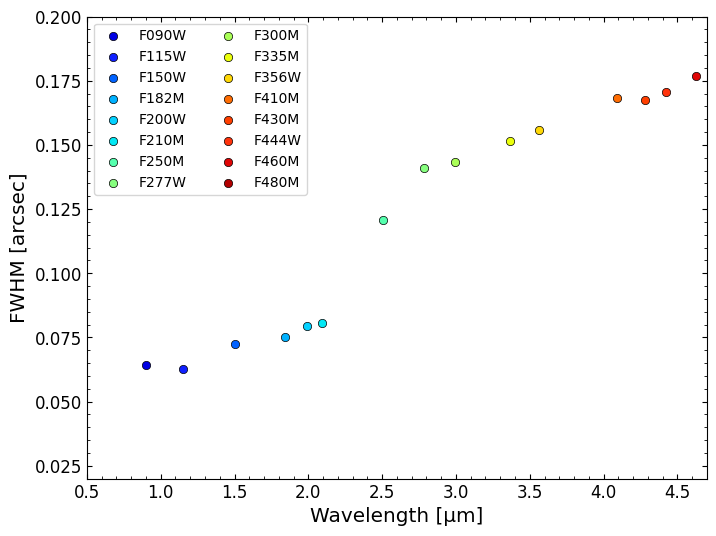

In [23]:
filters_waveband = {'F090W': {'pivot': 0.901, 'band': 0.194},
                    'F115W': {'pivot': 1.154, 'band': 0.225},
                    'F150W': {'pivot': 1.501, 'band': 0.318},
                    'F182M': {'pivot': 1.845, 'band': 0.238},
                    'F200W': {'pivot': 1.990, 'band': 0.461},
                    'F210M': {'pivot': 2.093, 'band': 0.205},
                    'F250M': {'pivot': 2.503, 'band': 0.181},
                    'F277W': {'pivot': 2.786, 'band': 0.672},
                    'F300M': {'pivot': 2.996, 'band': 0.318},
                    'F335M': {'pivot': 3.365, 'band': 0.347},
                    'F356W': {'pivot': 3.563, 'band': 0.787},
                    'F410M': {'pivot': 4.092, 'band': 0.436},
                    'F430M': {'pivot': 4.280, 'band': 0.228},
                    'F444W': {'pivot': 4.421, 'band': 1.024},
                    'F460M': {'pivot': 4.624, 'band': 0.228},
                    'F480M': {'pivot': 4.834, 'band': 0.303},}
# Source : https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-filters

fig, ax = plt.subplots(figsize=(8,6))
for i, filter in enumerate(filter_list):
    ax.scatter(FWHM['wavelength'][i], FWHM['fwhm'][i], color=color_dict[filter.upper()], edgecolors='k', lw=0.5, label=filter.upper())

ax.set_xlabel("Wavelength [µm]")
ax.set_ylabel("FWHM [arcsec]")
ax.set_ylim(0.02,0.2)
ax.set_xlim(0.5,4.7)
ax.legend(loc='upper left', ncol=2)
plt.show()